In [194]:
# Note, .all now needed?
from fastai2.tabular.all import *

In [195]:
Config().config_path

Path('/home/jupyter/.fastai')

In [ ]:
! kaggle competitions download competitive-data-science-predict-future-sales

In [196]:
p = Config().data/'competitive-data-science-predict-future-sales.zip'
assert p.exists()
path = Config().data/"competitive-data-science-predict-future-sales"
file_extract(p, dest=path)

In [201]:
ls '/home/jupyter/.fastai/data/competitive-data-science-predict-future-sales/' 

item_categories.csv  models/          sample_submission.csv  stage-1.pkl
items.csv            sales_train.csv  shops.csv              test.csv


In [202]:
table_names = ['item_categories', 'sales_train', 'shops', 'items', 'sample_submission', 'test']
tables = [pd.read_csv(path/f'{fname}.csv', low_memory=False) for fname in table_names]
item_categories, sales_train, shops, items, sample_submission, test = tables

In [ ]:
for fname in tables:
    print(fname.head())

In [219]:
train = sales_train
print(train.shape)
train.head()

(2935849, 6)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [220]:
print(test.shape)
test.head()

(214200, 3)


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [221]:
train = add_datepart(train, 'date', drop=False)

In [222]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-02-01,0,59,22154,999.00,1.0,2013,2,5,1,4,32,False,True,False,False,False,False,1359676800
1,2013-03-01,0,25,2552,899.00,1.0,2013,3,9,1,4,60,False,True,False,False,False,False,1362096000
2,2013-05-01,0,25,2552,899.00,-1.0,2013,5,18,1,2,121,False,True,False,False,False,False,1367366400
3,2013-06-01,0,25,2554,1709.05,1.0,2013,6,22,1,5,152,False,True,False,False,False,False,1370044800
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,3,15,1,15,False,False,False,False,False,False,1358208000


In [223]:
procs=[FillMissing, Categorify, Normalize]

In [224]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed'],
      dtype='object')

In [225]:
dep_var = 'item_cnt_day'
cat_names = ['date_block_num', 'shop_id', 'item_id',
        'Year', 'Month', 'Week', 'Day', 'Dayofweek',
       'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
       'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Elapsed']

cont_names = ['item_price']

df = train[cat_names + cont_names + [dep_var,'date']].copy()

In [226]:
cut = test.shape[0]
# make 2 lists, one for train, one for validation
splits = ( list(range(cut,len(train))), list(range(cut)) )

In [227]:
list(map(len,splits))

[2721649, 214200]

In [228]:
214200 / (2721649+214200)

0.07296015564833205

In [244]:
train[dep_var].min()

-22.0

In [245]:
train[dep_var].max()

2169.0

(-22, 2000)

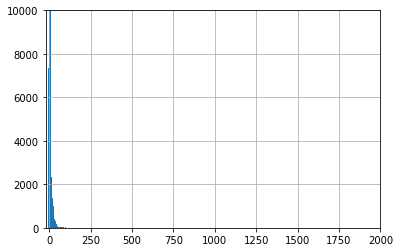

In [254]:
ax = train[dep_var].hist(bins=500)
ax.set_ylim((0,10000))
ax.set_xlim((-22,2000))

In [255]:
train[dep_var] = np.log(train[dep_var] + 22 + 1e-7 ) # urgh, must not rerun cell...

In [256]:
print( train[dep_var].min(), train[dep_var].max() )

-16.11809565095832 7.692113339641108


(0, 10)

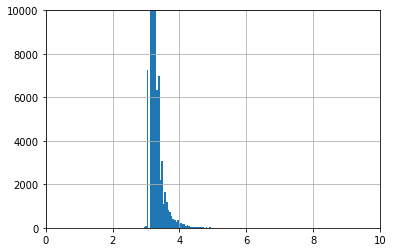

In [257]:
ax1 = train[dep_var].hist(bins=500)
ax1.set_ylim((0,10000))
ax1.set_xlim((0,10))

In [258]:
%time to = TabularPandas(train, procs, cat_names, cont_names, dep_var, y_block=TransformBlock(), splits=splits)

CPU times: user 26.6 s, sys: 1.24 s, total: 27.9 s
Wall time: 23.8 s


In [259]:
dls = to.dataloaders(bs=512, path=path)

In [260]:
dls.show_batch()

,date_block_num,shop_id,item_id,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_price,item_cnt_day
0,28,12,6073,2015,5,20,14,3,134,False,False,False,False,False,False,1431561600,999.000001,3.135494
1,24,27,17717,2015,1,4,20,1,20,False,False,False,False,False,False,1421712000,1998.999955,3.135494
2,30,19,20404,2015,7,31,30,3,211,False,False,False,False,False,False,1438214400,2399.000021,3.135494
3,6,31,1835,2013,7,31,29,0,210,False,False,False,False,False,False,1375056000,1499.000004,3.178054
4,13,5,2808,2014,6,23,2,0,153,False,False,False,False,False,False,1401667200,999.000001,3.135494
5,27,38,2252,2015,4,17,25,5,115,False,False,False,False,False,False,1429920000,399.000007,3.135494
6,33,7,10439,2015,10,43,19,0,292,False,False,False,False,False,False,1445212800,168.999988,3.135494
7,17,21,11415,2014,7,27,6,6,187,False,False,False,False,False,False,1404604800,148.999980,3.135494
8,17,5,10784,2014,6,24,13,4,164,False,False,False,False,False,False,1402617600,399.000007,3.135494
9,29,27,12452,2015,9,36,6,6,249,False,False,False,False,False,False,1441497600,498.999998,3.135494


In [261]:
max_log_y = np.log(1.2) + np.max(df[dep_var])
y_range = (0, max_log_y)
dls.c = 1

In [99]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=MSELossFlat(),
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range), 
                        metrics=exp_rmspe)

In [262]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(34, 12)
    (1): Embedding(59, 16)
    (2): Embedding(21150, 423)
    (3): Embedding(4, 3)
    (4): Embedding(13, 7)
    (5): Embedding(53, 15)
    (6): Embedding(32, 11)
    (7): Embedding(8, 5)
    (8): Embedding(366, 44)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(3, 3)
    (15): Embedding(1004, 77)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.001, inplace=False)
      (2): Linear(in_features=632, out_features=1000, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [101]:
len(dls.train_ds.cont_names)

1

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0012022644514217973)

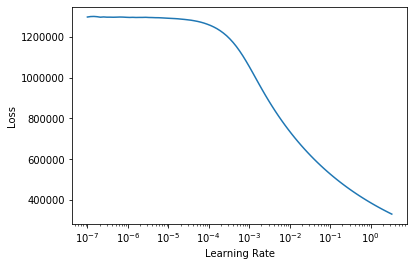

In [102]:
learn.lr_find()

In [103]:
learn.fit_one_cycle(10, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,_exp_rmspe,time
0,0.155101,0.155041,0.318405,01:45
1,0.148858,0.311943,0.947027,01:45
2,0.085432,0.107256,0.259165,01:46
3,0.057682,0.072282,0.180648,01:46
4,0.031413,0.050679,0.174138,01:46
5,0.020673,0.067049,0.194436,01:47
6,0.013175,0.063176,0.156552,01:46
7,0.008078,0.035893,0.125597,01:45
8,0.005695,0.020005,0.100771,01:45
9,0.004916,0.018828,0.098403,01:45


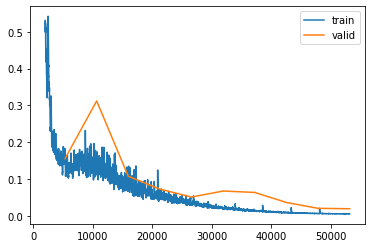

In [105]:
learn.recorder.plot_loss(skip_start=2000)

In [121]:
learn.show_results()

,date_block_num,shop_id,item_id,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,item_price,item_cnt_day,item_cnt_day_pred
0,1.0,7.0,4978.0,1.0,2.0,7.0,13.0,3.0,44.0,1.0,1.0,1.0,1.0,1.0,1.0,23.0,-0.173947,3.135494,3.141389
1,0.0,51.0,2761.0,1.0,1.0,4.0,26.0,6.0,26.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.400865,3.135494,3.157738
2,0.0,15.0,5055.0,1.0,1.0,4.0,25.0,5.0,25.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.202063,3.135494,3.160441
3,1.0,51.0,3913.0,1.0,2.0,7.0,13.0,3.0,44.0,1.0,1.0,1.0,1.0,1.0,1.0,23.0,0.053538,3.135494,3.152387
4,0.0,45.0,10786.0,1.0,1.0,3.0,19.0,6.0,19.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.003262,3.135494,3.148451
5,0.0,9.0,17071.0,1.0,1.0,5.0,30.0,3.0,30.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,-0.470729,3.135494,3.135962
6,0.0,40.0,10432.0,1.0,5.0,18.0,1.0,3.0,121.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0.905544,3.135494,3.139462
7,1.0,7.0,21130.0,1.0,1.0,1.0,2.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,-0.400865,3.135494,3.133040
8,1.0,50.0,7937.0,1.0,7.0,27.0,2.0,2.0,183.0,1.0,1.0,1.0,1.0,1.0,1.0,157.0,-0.419041,3.135494,3.151800


In [129]:
#Export
learn.export('stage-1.pkl')

In [138]:
learn.save('stafe-1-save') 

In [139]:
ls -tla '/home/jupyter/.fastai/data/competitive-data-science-predict-future-sales/'

total 293160
drwxr-xr-x  2 jupyter jupyter      4096 Jun 25 00:32 models/
-rw-r--r--  1 jupyter jupyter 198565227 Jun 25 00:21 stage-1.pkl
drwxr-xr-x  3 jupyter jupyter      4096 Jun 25 00:21 ./
-rw-r--r--  1 jupyter jupyter   3182735 Jun 24 22:29 test.csv
-rw-r--r--  1 jupyter jupyter   2245108 Jun 24 22:29 sample_submission.csv
-rw-r--r--  1 jupyter jupyter      2977 Jun 24 22:29 shops.csv
-rw-r--r--  1 jupyter jupyter  94603866 Jun 24 22:29 sales_train.csv
-rw-r--r--  1 jupyter jupyter   1568417 Jun 24 22:29 items.csv
-rw-r--r--  1 jupyter jupyter      3573 Jun 24 22:29 item_categories.csv
drwxr-xr-x 14 jupyter jupyter      4096 Jun 24 22:21 ../


In [209]:
#Import
learn = load_learner(path/'stage-1.pkl')

In [210]:
test.columns

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [211]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [145]:
learn.get_preds??

Signature:
learn.get_preds(
    ds_idx=1,
    dl=None,
    with_input=False,
    with_decoded=False,
    with_loss=False,
    act=None,
    inner=False,
    reorder=True,
    save_preds=None,
    save_targs=None,
    concat_dim=0,
)
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
Source:   
    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        if reorder and hasattr(dl, 'get_idxs'):
            idxs = dl.get_idxs()
            dl = dl.new(get_idxs = _ConstantFunc(idxs))
        cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
        ctx_mgrs = [self.no_logging(), self.added_cbs(cb), self.no_mbar()]
        if with_loss: ctx_mgrs.append(self.lo

In [142]:
dl = learn.dls??

Type:        TabularDataLoaders
String form: <fastai2.tabular.data.TabularDataLoaders object at 0x7f118b1ed810>
File:        ~/tutorials/fastai2/fastai2/tabular/data.py
Source:     
class TabularDataLoaders(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for tabular data"
    @classmethod
    @delegates(Tabular.dataloaders, but=["dl_type", "dl_kwargs"])
    def from_df(cls, df, path='.', procs=None, cat_names=None, cont_names=None, y_names=None, y_block=None,
                valid_idx=None, **kwargs):
        "Create from `df` in `path` using `procs`"
        if cat_names is None: cat_names = []
        if cont_names is None: cont_names = list(set(df)-set(cat_names)-set(y_names))
        splits = RandomSplitter()(df) if valid_idx is None else IndexSplitter(valid_idx)(df)
        to = TabularPandas(df, procs, cat_names, cont_names, y_names, splits=splits, y_block=y_block)
        return to.dataloaders(path=path, **kwargs)

    @classmethod
    def from

In [ ]:
dl = learn.dls

In [217]:
learn.get_preds??

Signature:
learn.get_preds(
    ds_idx=1,
    dl=None,
    with_input=False,
    with_decoded=False,
    with_loss=False,
    act=None,
    inner=False,
    reorder=True,
    save_preds=None,
    save_targs=None,
    concat_dim=0,
)
Docstring: Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`
Source:   
    @delegates(GatherPredsCallback.__init__)
    def get_preds(self, ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None,
                  inner=False, reorder=True, **kwargs):
        if dl is None: dl = self.dls[ds_idx].new(shuffled=False, drop_last=False)
        if reorder and hasattr(dl, 'get_idxs'):
            idxs = dl.get_idxs()
            dl = dl.new(get_idxs = _ConstantFunc(idxs))
        cb = GatherPredsCallback(with_input=with_input, with_loss=with_loss, **kwargs)
        ctx_mgrs = [self.no_logging(), self.added_cbs(cb), self.no_mbar()]
        if with_loss: ctx_mgrs.append(self.lo

In [140]:
len(preds) , 

(214200,)

In [213]:
testcp = test.copy()

In [214]:
testcp = testcp[cat_names + cont_names + [dep_var,'date']]

NameError: name 'cat_names' is not defined

In [215]:
dl = learn.dls.test_dl(testcp)

KeyError: "None of [Index(['item_price'], dtype='object')] are in the [columns]"

In [107]:
test_to = to.new(test)
test_to.process()

KeyError: "None of [Index(['item_price'], dtype='object')] are in the [columns]"

In [108]:
to.new??

Signature: to.new(df)
Docstring: <no docstring>
Source:   
    def new(self, df):
        return type(self)(df, do_setup=False, reduce_memory=False, y_block=TransformBlock(),
                          **attrdict(self, 'procs','cat_names','cont_names','y_names', 'device'))
File:      ~/tutorials/fastai2/fastai2/tabular/core.py
Type:      method
